In [4]:
## Loading / clustering data functions
import pandas as pd
import Bio.Phylo as bp
import scipy as sc

class TrueTree:
    """
    Data-like class meant to load the True Tree from the .phy file accompanying this package.
    
    Attributes:
        true_tree (Bio.Phylo.Tree): The true tree stored in a Bio.Phylo tree class.
    """
    
    def __init__(self):
        """
        Constructor for TrueTree data class.
        
        Paramters:
            None
        """
        self.true_tree = []
        
    def load_true_tree(self,file_path):
        """
        Function to load and parse the true tree, and store it.
        
        Parameters:
            file_path (string): A valid file path to the true tree .phy file
         
        Returns:
            Bio.Phylo.Tree: A Bio.Phylo Tree class storing the true tree.
        """
        self.true_tree = bp.read(file_path,'newick')
        return(self.true_tree)
        
class CNVData:
    """
    Data-like class meant to store a Species by Gene matrix with entries corresponding to gene Copy Number. A specific datafile is provided for working with reptilian species samples.
    
    Attributes:
        CNVData (pandas.DataFrame): A pandas DataFrame containing the CNV data matrix, with species as rows, and genes as columns. For this specific data-set, there are 91 species and 6491 orthologous genes across the 91 species. 
        
        label_replace_dictionary (dict): A dictionary storing phylogenetically correct names for some species in the given CNV data matrix. 
    """
    def __init__(self):
        """
        Constructor for CNVData data class.
        
        Paramters:
            None
        """
        
        self.CNVData = []
        self.label_replace_dictionary = {
        'SM1_centroids_nucleotides': 'Chelydra_serpentina',
        'SM2_centroids_nucleotides': 'Anolis_sagrei',
        'SM3_centroids_nucleotides': 'Elgaria_multicarinata',
        'SM4_centroids_nucleotides': 'Lamprophis',
        'SM5_centroids_nucleotides': 'Agkistrodon_piscivorus',
        'SM6_centroids_nucleotides': 'Xenopeltis_unicolor',
        'SM7_centroids_nucleotides': 'Alligator_mississippiensis',
        'SM8_centroids_nucleotides': 'Sceloporus_undulatus',
        'SM9_centroids_nucleotides': 'Pogona',
        'SM10_centroids_nucleotides': 'Sternotherus_odoratus',
        'SM11_centroids_nucleotides': 'Sternotherus_odoratus',
        'SM12_centroids_nucleotides': 'Scincella_lateralis',
        'SM13_centroids_nucleotides': 'Terrapene_carolina',
        'SM14_centroids_nucleotides': 'Agkistrodon_piscivorus',
        'SM15_centroids_nucleotides': 'Eublepharis_macularius',
        'TC_centroids_nucleotides': 'Thamnophis_sirtalis',
        'HS08_centroids_nucleotides': 'Thamnophis_elegans',
        'HS11_centroids_nucleotides': 'Thamnophis_couchii'
        }

    
    def readCNVMatrix(self,file_path):
        """
        Function to read the CNV data matrix from a .tsv file, and parse it correctly. NA's are replaced with 0s, and the copy numbers are min-max normalized across their species as a standardization method. Incorrectly named species are renamed using self.relabelIndex.
        
        Parameters:
            file_path (string): A valid file path to the .tsv CNV data file
            
        Returns:
            self.CNVData (pandas.DataFrame):  A pandas DataFrame containing the CNV data matrix, with species as rows, and genes as columns. For this specific data-set, there are 91 species and 6491 orthologous genes across the 91 species. The copy number values are normalized across species is heavily zero-inflated.
            
        """
        ## Read in data-file using Pandas. Assume TSV. Use column 1 as index. 
        ## Transpose so genes are columns. 
        self.CNVData = pd.read_csv(file_path,sep='\t', index_col=0).transpose()
        
        ## Drop unneccesary Column counting total CNV per species
        self.CNVData = self.CNVData.drop(['Total'])
        ## Replace NaN entries --> 0
        self.CNVData.fillna(0,inplace=True) 
        
        ## Min/max scaling of copy number
        self.CNVData = (self.CNVData - self.CNVData.min()) / (self.CNVData.max()-self.CNVData.min()) ## Min-max transform
        
        ## Replace NaN entries --> 0
        self.CNVData.fillna(0,inplace=True) 
        
        ## Relabel species names to line up with 'true' tree
        self.CNVData.index = self.relabelIndex(self.CNVData.index)
        
        return(self.CNVData)
    
    def relabelIndex(self,labels):
        """
        Function to relabel the indicies of a pandas DataFrame containing reptile species names with their correct phylogenetic names using the class attribute self.label_replace_dictionary.
        
        Parameters:
            labels (pandas.DataFrame.index): An index of a pandas DataFrame containing reptile species names. Behaves like a list object 
            
        Returns:
            fixed_labels (list): A list object containing the corrected phylogenetic names of reptile species passed in labels.
        
        """
        ## init correct name matrix
        fixed_labels = []

        ## Iterate over the labels
        for label in labels:
            ## if it must be fixed, lookup in label_replace_dictionary and store the fixed name 
            ## or store the name if not.
            if label in self.label_replace_dictionary:
                fixed_labels.append(self.label_replace_dictionary[label])
            else:
                fixed_labels.append(label)
        return(fixed_labels)

In [5]:
import scipy.cluster as sc
from io import StringIO
import numpy as np

class Cluster: 
    """
    """
    def __init__(self): ## takes a CNVData matrix. 
        self.trees = []
        self.clust_ids=[]
        self.random_trees=[]
        self.random_clust_ids=[]
        self.available_methods = ['single','complete','average',
                                  'weighted','ward','median','centroid']
        self.available_distances=['braycurtis', 'canberra', 'chebyshev', 
                                  'cityblock', 'correlation', 'cosine', 
                                  'dice', 'euclidean', 'hamming', 'jaccard', 
                                  'jensenshannon', 'kulsinski', 'mahalanobis',
                                  'matching', 'minkowski', 'rogerstanimoto', 
                                  'russellrao', 'seuclidean', 'sokalmichener', 
                                  'sokalsneath', 'sqeuclidean', 'yule']
        
    def cluster(self,data,method=None,distance=None):
        """   
        Function to use 

        """
        ## try to load the method. 
        if method:
            try:
                self.available_methods.index(method)
            except ValueError:
                raise Exception('Selected clustering method not available.')
        else:
            method = 'ward'
          
        if distance:
            try:
                self.available_distances.index(distance)
            except ValueError:
                raise Exception('Selected distance metric not available.')
        else:
            distance = 'euclidean'
            
        
        rand = data.copy()
        num_zeroes = (data.values==0).sum()
        val_max = data.values.max()
 
        for x in range(0,100):
            
            boot_tree, boot_clust_id = self.cluster_single(data.sample(data.shape[1],replace=True,axis=1),method)
            
            self.trees.append(boot_tree)
            self.clust_ids.append(boot_clust_id)
            
            rand_tree, rand_clust_id = self.cluster_single(self.generate_random(rand,val_max,num_zeroes),method)
            
            self.random_trees.append(rand_tree)
            self.random_clust_ids.append(rand_clust_id)
                    
        return self.trees, self.random_trees, self.clust_ids, self.random_clust_ids

    def cluster_single(self,data,method):
        link = sc.hierarchy.linkage(data,method)
        tree = sc.hierarchy.to_tree(link)
        
        cluster_id = dict(zip(data.index,sc.hierarchy.cut_tree(link,n_clusters=4).T.tolist()[0]))
        
        cluster_newick = self.getNewick(tree, "", tree.dist, data.index)
        cluster_phylo = bp.read(StringIO(cluster_newick),'newick')
        return cluster_phylo, cluster_id

    
    def getNewick(self,node, newick, parentdist, leaf_names):
        """
        Function to 
        """
        if node.is_leaf():
            return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
        else:
            if len(newick) > 0:
                newick = "):%.2f%s" % (parentdist - node.dist, newick)
            else:
                newick = ");"
            newick = self.getNewick(node.get_left(), newick, node.dist, leaf_names)
            newick = self.getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
            newick = "(%s" % (newick)
            return newick
        
    def generate_random(self,rm,maxval,zeroes):
        randarray = np.random.random_sample(rm.values.size)*maxval
        randarray[np.random.choice(np.arange(0,rm.values.size-1),zeroes,replace=False)] = 0
        rm.iloc[:,:] = randarray.reshape(rm.shape)
        return(rm)

        
        

In [6]:
tr = TrueTree().load_true_tree('data/phyliptree.phy')
dm = CNVData().readCNVMatrix('data/LS_blastn_Gar_noDenom.txt')
cl,rn,cl_id,rn_id = Cluster().cluster(dm,'ward',distance='euclidean')

In [8]:
from cluster_grading import grade as cg

In [9]:
ari_clusters, ari_random = cg(dm.index, cl, rn, cl_id,rn_id,tr)

In [10]:
from phylotree import plot_trees

In [26]:
ac=pd.Series(ari_clusters)
ac.idxmax()

0.25730286479307024

In [28]:
plot_trees(tr, cl[ac.idxmax()])

True Tree
                  _____ Eublepharis macularius
             ____|
            |    |_____ Gekko japonicus
            |
            |     _____ Scincella lateralis
       _____|    |
      |     |    |      ____ Elgaria multicarinata
      |     |    |     |
      |     |    |     |           ____ Xenopeltis unicolor
      |     |    |     |          |
      |     |____|     |     _____|____ Python bivittatus
      |          |     |    |     |
      |          |     |    |     |____ Candoia aspera
      |          |     |    |
      |          |     |____|      ____ Lamprophis
      |          |     |    |     |
      |          |     |    |     |     _____ Thamnophis sirtalis
      |          |_____|    |     |    |
      |                |    |_____|____|_____ Thamnophis elegans
      |                |          |    |
      |                |          |    |_____ Thamnophis couchii
      |                |          |
      |                |          |     _____ Protoboth

In [58]:
from phylotree import plot_dist
import matplotlib.pyplot as plt
import seaborn as sns

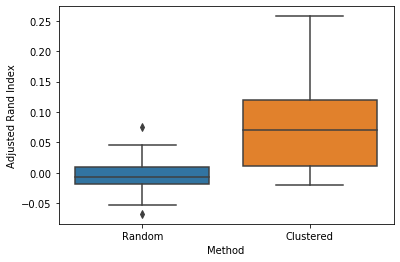

In [65]:
rand = pd.Series(ari_random)
clust = pd.Series(ari_clusters)
dist = pd.DataFrame(pd.concat([rand,clust], axis=1))
dist.columns = ['Random','Clustered']

sns.boxplot(x="variable", y="value", data=pd.melt(dist))
plt.ylabel('Adjusted Rand Index')
plt.xlabel('Method')
plt.show()

In [38]:
rand


0     0.045797
1     0.008937
2    -0.010640
3    -0.000502
4    -0.001038
        ...   
95   -0.036769
96   -0.008659
97   -0.012869
98   -0.036432
99    0.024657
Length: 100, dtype: float64